# Evaluating Earthquake Damage in Nepal 

The culminating task for the [Microsoft Professional Program in Data Science](https://academy.microsoft.com/en-us/professional-program/tracks/data-science/) is to develop a report for a machine learning task which highlights the full cycle of data analysis from exploratory data analysis, to statistical modeling, and finally communicating those results.  In this task we will use building location and construction to predict the level of damage to buildings caused by the 2015 Gorkha earthquake in Nepal.  This data is provided by [DrivenData](https://www.drivendata.org/).

## Exploratory Data Analysis

The goals of our exploration are in part informed by the questions that are being asked as part of the program, however generally of course we would like to try to discover which variables contain a lot of information.  One approach I will use as a part of my feature engineering is use FeatureTools, which will hopefully improve the quality of our results.  We will want to explore multiple different approaches to this problem. 

In [258]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [259]:
# Training examples and labels are already split for us.  A quick check of the building_id variables
# confirms that they are ordered the same
data = pd.read_csv("data/train_values.csv")
labels = pd.read_csv("data/train_labels.csv")
# We'll merge the dataset for come convenience when visualizing
merged = data.merge(labels)
# The Test Data set
test = pd.read_csv("data/test_values.csv")

In [260]:
data.shape

(10000, 39)

### Exploring the Distributions of Each Variable

I have a few things that I want to understand about a distribution when getting started on a project:
  * What are the distributions of each variable?
  * How are the features correllated with the response variable?
  * How are the feature correllated with each other?
  * Are there missing values?
  
#### Distributions of each variable

From these histograms I notice several things.  We have a mix of categorical and numeric variables which describe building attributes (like how tall it is), how it is used (industry, etc...), and its locations.  

Building Attributes:
  * age
  * area
  * has_superstructure
  * height
  * count_floors_pre_eq
  * land_surface_condition
  * foundation_type
  * roof_type
  * ground_floor_type
  * other_floor_type
  
Building Use:
  * legal_ownership_status
  * has_secondary_use
  * count_families

Building Location:
  * geo_level_1_id
  * geo_level_2_id
  * geo_level_3_id
  * land_surface_condition
  * position
  * plan_configuration


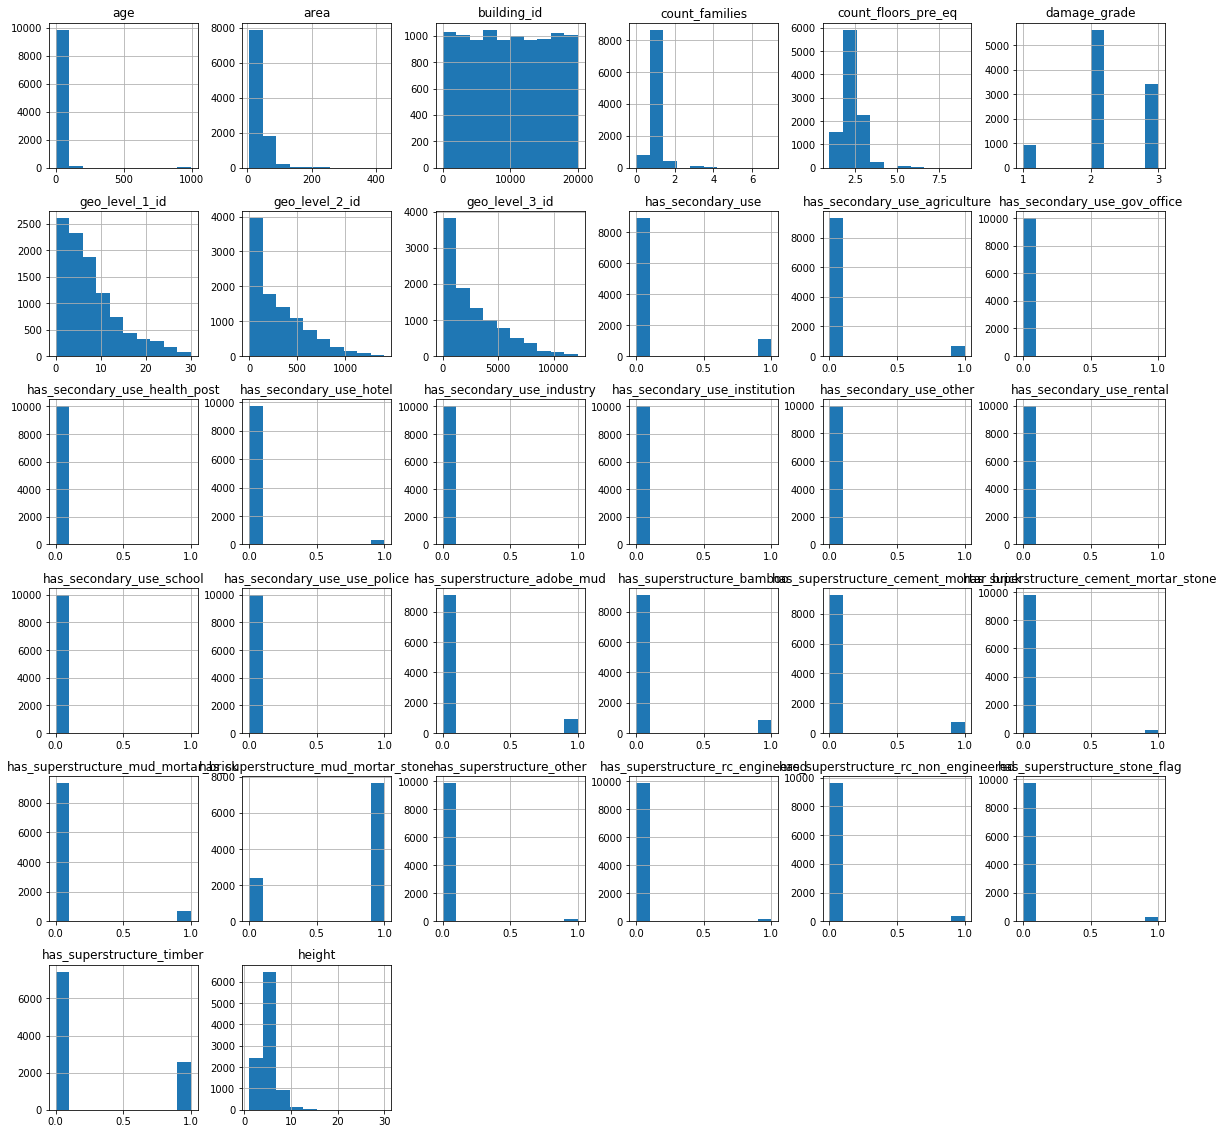

In [261]:
merged.hist(figsize=(20, 20))
plt.show()

#### Correlation

First we display the pearson r values for damage grade with each other variable.  Then we display the correlation matrix for all variables in a headmap.  A few things to notice, that certain super structures seem to be highly corrlated with higher (adobe, stone) or lower (cement/rc) damage grades.  Area also is clearly negative and floor count is clearly positive.  The rest are pretty close to zero and may or may not be important. 

has_superstructure_cement_mortar_brick   -0.233398
has_superstructure_rc_engineered         -0.179761
has_superstructure_rc_non_engineered     -0.156371
area                                     -0.114775
has_secondary_use                        -0.087286
has_secondary_use_hotel                  -0.085269
has_superstructure_timber                -0.080558
has_superstructure_cement_mortar_stone   -0.073337
has_superstructure_bamboo                -0.072327
geo_level_1_id                           -0.064084
has_secondary_use_rental                 -0.063367
has_secondary_use_school                 -0.041652
has_secondary_use_other                  -0.031927
has_secondary_use_institution            -0.029296
has_superstructure_other                 -0.019515
has_secondary_use_gov_office             -0.017306
has_secondary_use_agriculture            -0.013333
has_secondary_use_industry               -0.011504
building_id                              -0.008632
geo_level_2_id                 

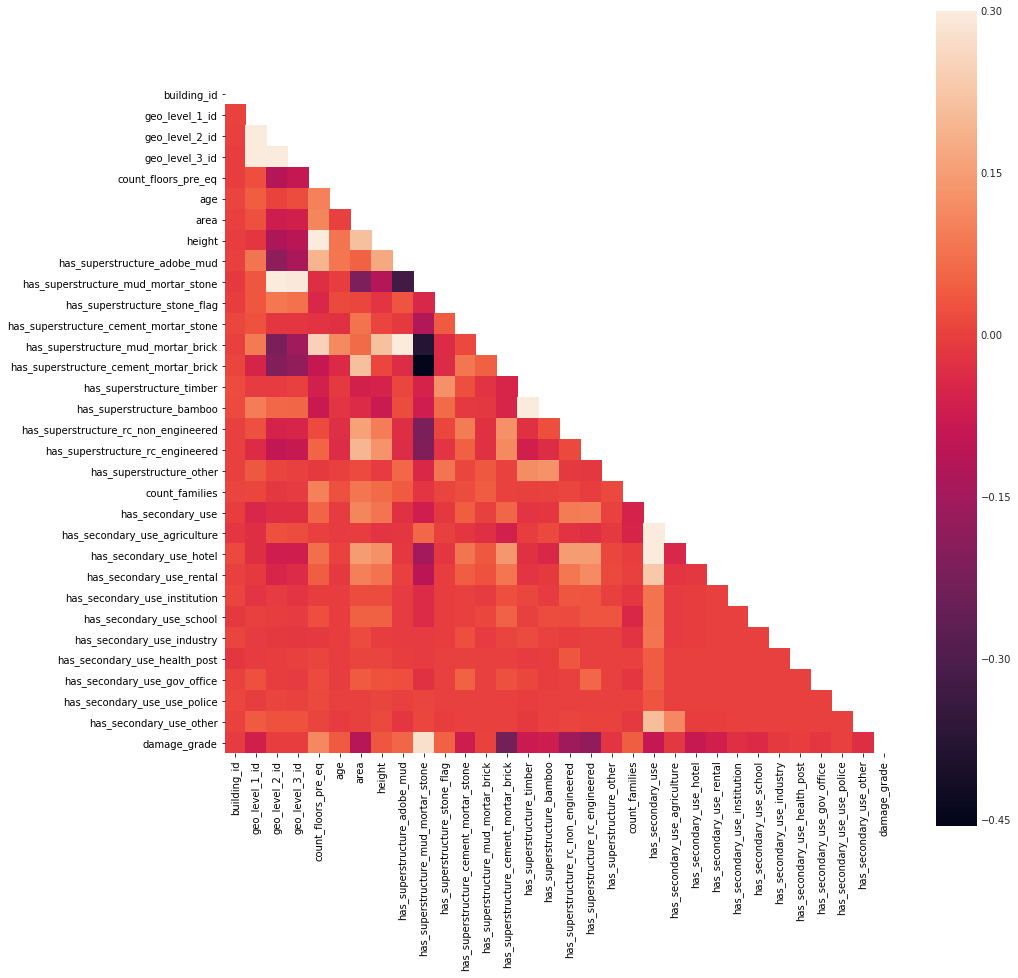

In [262]:
f, axs = plt.subplots(1, figsize=(15, 15))
cor = merged.corr()
print(cor['damage_grade'].sort_values())
mask = np.zeros_like(cor)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(cor, mask=mask, vmax=.3, square=True, ax=axs)
plt.show()

#### Missing Values

We can do simple checks for missing values by, for example, summing up the counts of NaNs in each column.  It seems like we are safe from missing values so far.

In [263]:
merged.isnull().sum()

building_id                               0
geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area                                      0
height                                    0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo       

In [264]:
### Cross Variable Comparisons

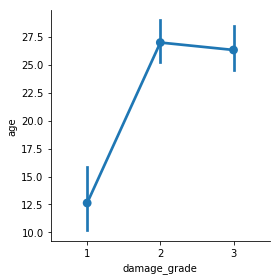

In [265]:
# How does Building Age correspond to damage grade?
sns.factorplot(x="damage_grade", y="age", data=merged)
# Observe that the average age for 1st grade damage was significantly lower than 2's and 3's. 

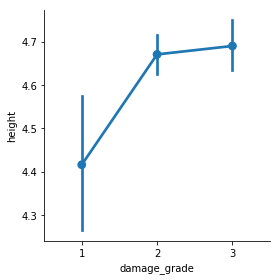

In [266]:
# Building Height versus Damage Grade
sns.factorplot(x="damage_grade", y="height", data=merged)
# Building height for grade 1's was slightly lower, though perhaps not significantly different 
# from 2's and 3's.  Maybe 2's and 3's contain more outliers though.

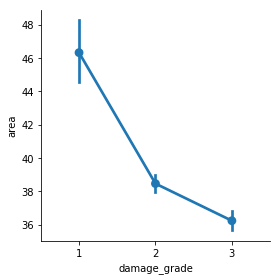

In [267]:
# Building Area versus Damage Grade
sns.factorplot(x="damage_grade", y="area", data=merged)
# We notice that lower damage grades seem to correspond to 

#### Learnings from Exploratory Data Analysis

##### Damage Grade Seperation

Our ultimate task is to try to differentiate examples into damages grades 1, 2, or 3.  Our visualization of some variables suggests that perhaps grades 1 and 2/3 are fairly easy to seperate, but the seperation between 2 and 3 seems to be the more challenging task.

##### Location Data

In this task location data is given in a non-traditional way.  We are given ids which correspond to increasingly granular location ids.  However, there is no reason to believe that the numeric values are actually meaningful.  Therefore, these values are really categorical in nature.  This is likely where we will get the most use out of Feature Tools.

### Feature Engineering with Feature Tools

Okay, we'll now utilize the Feature Tools package to prepare our data for machine learning.

In [268]:
import featuretools as ft

In [269]:
# Feature tools will do its best auto detect the dtypes of our variables.  However we'll need to make some corrections.
dtypes = {
    'damage_grade': ft.variable_types.Categorical,
    'has_superstructure_adobe_mud': ft.variable_types.Boolean,
    'has_superstructure_mud_mortar_stone': ft.variable_types.Boolean, 
    'has_superstructure_stone_flag': ft.variable_types.Boolean,
    'has_superstructure_cement_mortar_stone': ft.variable_types.Boolean,
    'has_superstructure_mud_mortar_brick': ft.variable_types.Boolean,
    'has_superstructure_cement_mortar_brick': ft.variable_types.Boolean, 
    'has_superstructure_timber': ft.variable_types.Boolean,
    'has_superstructure_bamboo': ft.variable_types.Boolean, 
    'has_superstructure_rc_non_engineered': ft.variable_types.Boolean,
    'has_superstructure_rc_engineered': ft.variable_types.Boolean, 
    'has_superstructure_other': ft.variable_types.Boolean,
    'has_secondary_use': ft.variable_types.Boolean,
    'has_secondary_use_agriculture': ft.variable_types.Boolean, 
    'has_secondary_use_hotel': ft.variable_types.Boolean,
    'has_secondary_use_rental': ft.variable_types.Boolean,
    'has_secondary_use_institution': ft.variable_types.Boolean,
    'has_secondary_use_school': ft.variable_types.Boolean, 
    'has_secondary_use_industry': ft.variable_types.Boolean,
    'has_secondary_use_health_post': ft.variable_types.Boolean, 
    'has_secondary_use_gov_office': ft.variable_types.Boolean,
    'has_secondary_use_use_police': ft.variable_types.Boolean, 
    'has_secondary_use_other': ft.variable_types.Boolean
}

In [282]:
# Start be definng an EntitySet.  This abstractly contains all data we'll use to train the model, potentially in multiple tables. 
es = ft.EntitySet(id="Buildings")

merged.reset_index(inplace=True)
# With the container defined, we'll add our data
es = es.entity_from_dataframe(entity_id='buildings',
                              dataframe=merged,
                              variable_types=dtypes,
                              index="index")

# This method will generate a new entity for each entry in Geo 1.  Since
# earthquake damage will likely be very related to location, we'll want to 
# try to leverage location data in this way. 
es = es.normalize_entity(base_entity_id="buildings",
                         new_entity_id="geo_1",
                         index="geo_level_1_id")

# This method will traverse our categorical variables and identify interesting values to construct
# where variables from
es.add_interesting_values(max_values=20, verbose=False)

In [283]:
from featuretools.primitives import (Mean, Count, Skew, Sum, Std, PercentTrue, Mode, CumSum,
                                     CumCount, CumMean, Median)

# Yields our base feature matrix and defs
base_mat, base_defs = ft.dfs(entityset=es,
                               target_entity='buildings',
                               drop_contains=['geo_level_2_id', 'geo_level_3_id'],
                               agg_primitives=[],
                               max_depth=1)

# Generates many features based on each entry in geo_1.  This hopefully captures important geographic features.
geo_1_mat, geo_1_defs = ft.dfs(entityset=es,
                               target_entity='geo_1',
                               agg_primitives=[Mean, Skew, Sum, Std, PercentTrue, Mode],
                               where_primitives=[Sum, Count, Mean, PercentTrue],
                               max_depth=3)

In [284]:
basemat_encoded, base_encoded = ft.encode_features(base_mat, base_defs, include_unknown=False,
                                                   to_encode=['land_surface_condition', 'foundation_type',
                                                              'roof_type', 'ground_floor_type', 'other_floor_type',
                                                              'position', 'plan_configuration', 'legal_ownership_status'])
geomat_encoded, geo_encoded = ft.encode_features(feature_matrix, feature_defs, include_unknown=False)
geomat_encoded.reset_index(inplace=True)

In [285]:
# Our base dataset without extra geo features
base = basemat_encoded
# Added geo features
base_with_geo = basemat_encoded.merge(geomat_encoded)

### Feature Preparation

Now that we've generated a bunch of potentially useful features, we need apply the last few steps of cleaning to our dataset. 

This will include:
  * Ensuring all columns are normalized
  * Dropping features which contribute to noise (ids)
  * Dropping any columns which are all a single value
  
We utilized code from this blog post on pipelines for scikit learn, in particular to get this nice ability to give and return pandas dataframes.

In [371]:
from sklearn.preprocessing import RobustScaler

def preprocessing(data):
    X, y = data.drop('damage_grade', axis=1), data['damage_grade']
    # At this point, any NA's can just be filled with 0.  
    X.fillna(0, inplace=True)
    # Drop columns which have no information value
    X = drop_unused(X)
    # Drop any columns which only have a single value
    X = drop_trivial(X)
    # Scale our numeric cols
    X = norm_cols(X)
    return X, y

def drop_trivial(data):
    """If a column only has 1 value, drop it"""
    for col in data.columns:
        if len(data[col].unique()) == 1:
            data.drop(col,inplace=True,axis=1)            
    return data

def drop_unused(data):
    cols = ['geo_level_1_id']
    return data.drop(cols, axis=1)

def norm_cols(data):
    # Identify columns in need of scaling by those who have more than two values
    numeric = data.loc[:, (data.apply(lambda x: len(x.unique())) > 2).values].columns
    scaler = RobustScaler()
    scaled = pd.DataFrame(scaler.fit_transform(data[numeric]), columns=numeric)
    for column in numeric:
        data[column] = scaled[column]
    return data

In [374]:
X, y = preprocessing(base)

In [376]:
X.head()

,count_floors_pre_eq,age,area,height,land_surface_condition = d502,land_surface_condition = 808e,land_surface_condition = 2f15,foundation_type = 337f,foundation_type = 858b,foundation_type = 6c3e,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.50,-0.055556,-1.0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,0.00,-0.333333,0.0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-1.0,0.25,0.166667,-3.0,1,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0.0,-0.50,-0.888889,-2.0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,-0.75,0.277778,1.0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
